# Ensambles w/ Stacking

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.tree import ExtraTreeRegressor
from sklearn import preprocessing



In [2]:
# Load the boston housing data
boston_house_data = load_boston()

# Create a data frame of samples and feature values.
data_X_df = pd.DataFrame(boston_house_data.data, columns=boston_house_data.feature_names)
data_X_df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


## Preprocessing 

### Standardization

Note: we will remove teh mean and scale the variance to help speed up the training.


In [3]:
data_scaler = preprocessing.MinMaxScaler()
target_scaler = preprocessing.MinMaxScaler()

data = data_scaler.fit_transform(boston_house_data.data)
target = target_scaler.fit_transform(boston_house_data.target)
# data = data_X_df.values
# target = boston_house_data.target

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [4]:
# Print the dimensions of train and test data.
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=4)
print "Dimension of X_train =", X_train.shape
print "Dimension of y_train =", y_train.shape
print "Dimension of X_test =", X_test.shape
print "Dimension of y_test =", y_test.shape

Dimension of X_train = (379, 13)
Dimension of y_train = (379,)
Dimension of X_test = (127, 13)
Dimension of y_test = (127,)


## Stacking Testbench

### Stacker Helper

I have a simple stacking routine:

In [5]:
class StackedRegressor():

    def __init__(self, base_regressors, meta_regressor):
        """Constructor for StackedRegressor. Takes list of base_regressors and a meta_regressor"""
        self.__base_regressors = base_regressors
        self.__meta_regressor = meta_regressor
        self.__kbest = None

    def fit(self, X, y, split=True, kbest=None):

        if kbest:
            kb = SelectKBest(f_regression, k=kbest).fit(X, y)
            self.__kbest = kb.scores_.argsort()[-kbest:]
            X = X[:, self.__kbest]
        if split:
            # Split the data so that it will not over fit.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)
        else:
            X_train, X_test, y_train, y_test = X, X, y, y
        
        # Fit and predict the train data on the level0 regressors.
        meta_input = [regressor.fit(X_train, y_train).predict(X_test) for regressor in self.__base_regressors]
        
        # Fit the predicted values of above level 0 classifiers into meta regressor
        X_meta = np.array(meta_input).transpose()
        self.__meta_regressor.fit(X_meta, y_test)
        return self

    def predict(self, X):
        if not self.__kbest is None:
            X = X[:, self.__kbest]
        
        # Predict the test data on level0 regressors
        self.base_regressors_predict_ = [regressor.predict(X) for regressor in self.__base_regressors]
        
        # Predict the final values.
        X_meta = np.array(self.base_regressors_predict_).transpose()
        
        return self.__meta_regressor.predict(X_meta)

    def scores(self, X, y):
        if not self.__kbest is None:
            X = X[:, self.__kbest]

        X_meta = np.array([regressor.predict(X) for regressor in self.__base_regressors]).transpose()
        self.score_base_regressors_ = [regressor.score(X, y) for regressor in self.__base_regressors]
        self.score_meta_regressor_ = self.__meta_regressor.score(X_meta, y)

        self.mse_base_regressors_ = [mean_squared_error(y, X_meta[:, i]) for i in range(X_meta.shape[1])]
        self.mse_meta_regressor_ = mean_squared_error(y, self.__meta_regressor.predict(X_meta))

### Evaluation

I also have a simple routine to test my ensemable:


In [6]:
def evaluate_model(base_regressors, meta_regressor, names, split=True, kbest=None):
    stacked_regressor = StackedRegressor(base_regressors=base_regressors, meta_regressor=meta_regressor)
    stacked_regressor.fit(X_train, y_train, split, kbest)
    stacked_regressor.scores(X_test, y_test)
    print "Scores of base regressors on test data =", stacked_regressor.score_base_regressors_
    print "Score of meta regressor on test data =", stacked_regressor.score_meta_regressor_

    print "Mean squared error of base regressors on test data =", stacked_regressor.mse_base_regressors_
    print "Mean squared error of meta regressor on test data =", stacked_regressor.mse_meta_regressor_

    predicted_y = stacked_regressor.predict(X_test)
    df = pd.DataFrame(stacked_regressor.base_regressors_predict_ + [predicted_y, y_test],index=names + ["Original"]).T
    df2 = pd.DataFrame(
        {"MSE": stacked_regressor.mse_base_regressors_ + [stacked_regressor.mse_meta_regressor_],
        "SCORE" : stacked_regressor.score_base_regressors_ + [stacked_regressor.score_meta_regressor_]}, 
        index=names)
    df2.plot(kind='bar', alpha=0.5, grid=True, rot=45, subplots=True, layout=(1,2), legend=False, figsize=(12, 4))
    return df

## Experiments

### 1

**Base regressors:**

- ExtraTreeRegressor with max_depth=2

- LinearRegression

**Meta regressor**

- Ridge

**Best features**

- 5 best features are choosen based on f_regression.

Scores of base regressors on test data = [0.2747178207417893, 0.69832284909850706]
Score of meta regressor on test data = 0.676987346239
Mean squared error of base regressors on test data = [0.035935860470215464, 0.014947324381988751]
Mean squared error of meta regressor on test data = 0.0160044434947


,Extra Tree (max_depth=2),Linear Regression,Stacked Regressor,Original
0,0.457636,0.172544,0.215932,0.255556
1,0.457636,0.486412,0.479380,0.440000
2,0.314010,0.297049,0.292956,0.275556
3,0.314010,0.167674,0.184365,0.317778
4,0.709899,0.706721,0.712563,0.724444


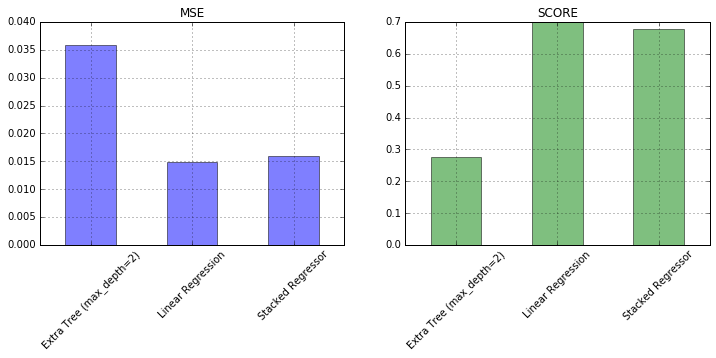

In [7]:
base_regressors=[ExtraTreeRegressor(max_depth=2), LinearRegression()]
meta_regressor = Ridge(alpha=0.5)
names = ["Extra Tree (max_depth=2)", "Linear Regression", "Stacked Regressor"]
evaluate_model(base_regressors, meta_regressor, names, split=True, kbest=5).head()

### 2

**Base regressors:**

- DecisionTreeRegressor with max_depth=2

- DecisionTreeRegressor with max_depth=3

**Meta regressor**

- DecisionTreeRegressor with max_depth=3


**Details**

- We split the train data into sets so that decision tree regressor dont perfectly predict.

- Default parameters of DecisionTreeRegressor perfectly predicts the train data so we must be careful.

- Use max_depth=2 to reduce over fitting.

- Stacking in this case improves but not a lot.

Scores of base regressors on test data = [0.63579187940592352, 0.63247573799950796]
Score of meta regressor on test data = 0.616813839381
Mean squared error of base regressors on test data = [0.01804557257586855, 0.018209878825613066]
Mean squared error of meta regressor on test data = 0.0189858854883


,Decision Tree (max_depth=2),Decision Tree (max_depth=3),Stacked Regressor,Original
0,0.194932,0.229298,0.236809,0.255556
1,0.389744,0.383819,0.389396,0.440000
2,0.389744,0.383819,0.389396,0.275556
3,0.194932,0.229298,0.236809,0.317778
4,0.875758,0.925778,0.920317,0.724444


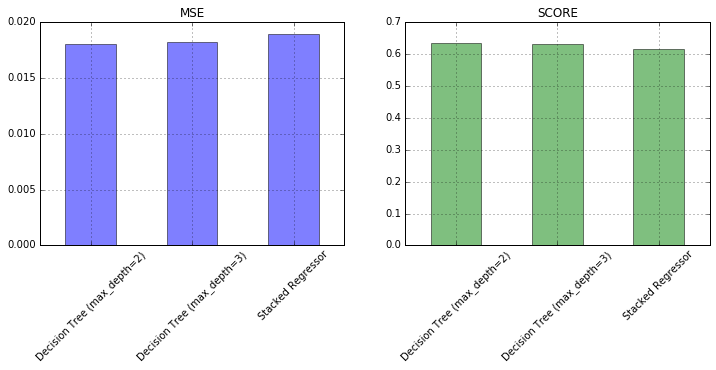

In [8]:
base_regressors=[DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3)]
meta_regressor = DecisionTreeRegressor(max_depth=3)
names = ["Decision Tree (max_depth=2)", "Decision Tree (max_depth=3)", "Stacked Regressor"]
evaluate_model(base_regressors, meta_regressor, names).head()

### 3

**Base regressors:**

- DecisionTreeRegressor with max_depth=2

- DecisionTreeRegressor with max_depth=3

**Meta regressor**

- LinearRegression

**Details**

- Stacked model improves a bit but not a lot. This could be because the the DecisionTreeRegressor with depth=3 is a good classifier.

Scores of base regressors on test data = [0.63579187940592352, 0.63247573799950796]
Score of meta regressor on test data = 0.628166299997
Mean squared error of base regressors on test data = [0.018045572575868547, 0.018209878825613066]
Mean squared error of meta regressor on test data = 0.0184234003586


,Decision Tree (max_depth=2),Decision Tree (max_depth=3),Stacked Regressor,Original
0,0.194932,0.229298,0.216873,0.255556
1,0.389744,0.383819,0.383022,0.440000
2,0.389744,0.383819,0.383022,0.275556
3,0.194932,0.229298,0.216873,0.317778
4,0.875758,0.925778,0.818713,0.724444


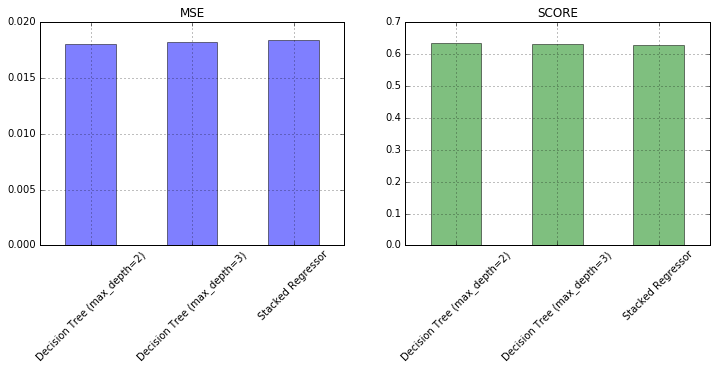

In [9]:
base_regressors=[DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3)]
meta_regressor = LinearRegression()
names = ["Decision Tree (max_depth=2)", "Decision Tree (max_depth=3)", "Stacked Regressor"]
evaluate_model(base_regressors, meta_regressor, names).head()

### 4

**Base regressors:**

- DecisionTreeRegressor with max_depth=2

- LinearRegression

**Meta regressor**

- Ridge

**Details**

- Stacked model improves a lot in this case. Here we chose 2 weak regressors in level 0.

- Train data is not split in training phase.

- The predicted 


Scores of base regressors on test data = [0.63579187940592352, 0.74362478849407732]
Score of meta regressor on test data = 0.746682965603
Mean squared error of base regressors on test data = [0.018045572575868547, 0.012702730181681247]
Mean squared error of meta regressor on test data = 0.0125512053972


,Decision Tree (max_depth=2),Linear Regression,Stacked Regressor,Original
0,0.194932,0.130278,0.162273,0.255556
1,0.389744,0.480543,0.436035,0.440000
2,0.389744,0.268457,0.312494,0.275556
3,0.194932,0.249260,0.231580,0.317778
4,0.875758,0.736575,0.759139,0.724444


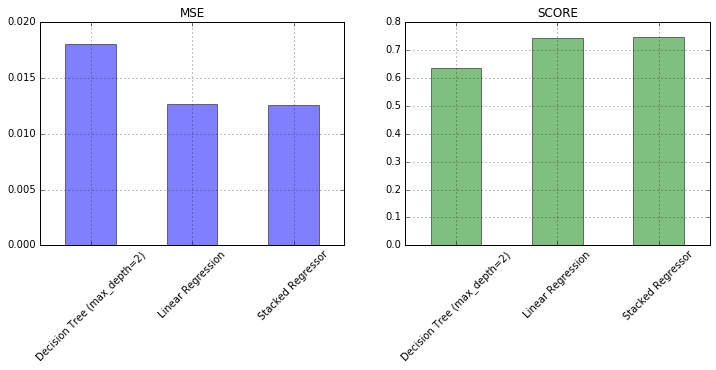

In [10]:
base_regressors=[DecisionTreeRegressor(max_depth=2), LinearRegression()]
meta_regressor = Ridge()
names = ["Decision Tree (max_depth=2)", "Linear Regression", "Stacked Regressor"]
evaluate_model(base_regressors, meta_regressor, names).head()

### 5

**Base regressors:**

- Ridge

- LinearRegression

**Meta regressor**

- LinearRegression

**Details**

- Stacked model improves very less in this case. This is expected because there is no additional refinement on intermediate predicted values.

Scores of base regressors on test data = [0.71996212026890405, 0.74362478849407732]
Score of meta regressor on test data = 0.722948935003
Mean squared error of base regressors on test data = [0.013875154333288718, 0.012702730181681247]
Mean squared error of meta regressor on test data = 0.0137271653704


,Ridge,Linear,Stacked,Original
0,0.184764,0.130278,0.184683,0.255556
1,0.476263,0.480543,0.484454,0.440000
2,0.301190,0.268457,0.305672,0.275556
3,0.284814,0.249260,0.288479,0.317778
4,0.682497,0.736575,0.690520,0.724444


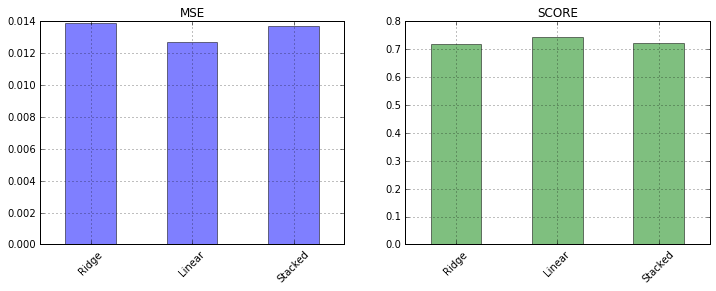

In [11]:
base_regressors=[Ridge(), LinearRegression()]
meta_regressor = LinearRegression()
names = ["Ridge", "Linear", "Stacked"]
evaluate_model(base_regressors, meta_regressor, names).head()

### 6

**Base regressors:**

- SVR

- LinearRegression

**Meta regressor**

- GradientBoostingRegressor

**Details**

- Stacked model improves a lot in this case. Here we chose 2 weak regressors in level 0.

- Train data is not split in training phase.

- The predicted 



Scores of base regressors on test data = [0.82391286504364492, 0.74362478849407732]
Score of meta regressor on test data = 0.857523516995
Mean squared error of base regressors on test data = [0.0087246631633269098, 0.012702730181681247]
Mean squared error of meta regressor on test data = 0.00705934208777


,SVR,LR,Stacked Regressor (GBR),Original
0,0.069255,0.130278,0.108474,0.255556
1,0.496389,0.480543,0.441441,0.440000
2,0.312052,0.268457,0.262614,0.275556
3,0.365077,0.249260,0.329880,0.317778
4,0.825166,0.736575,0.943346,0.724444


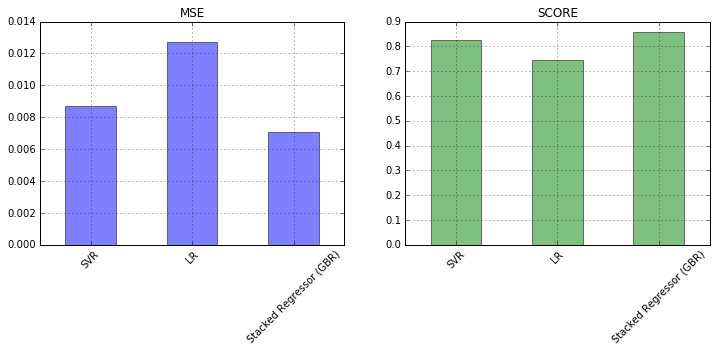

In [12]:
from sklearn.svm import SVR
from sklearn import ensemble
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

from sklearn.linear_model import LinearRegression
lm_model = LinearRegression()

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1, 'learning_rate': 0.01, 'loss': 'ls'}
gb_clf = ensemble.GradientBoostingRegressor(**params)

base_regressors=[svr_poly, lm_model]
meta_regressor = gb_clf
names = ["SVR", "LR", "Stacked Regressor (GBR)"]
evaluate_model(base_regressors, meta_regressor, names, split=True, kbest=None).head()